# Regression: predict RON and Cocking Rate

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


### Get the data
Import dataset using pandas.

In [2]:
dataset_path = 'Case_study_20190812.csv'
raw_dataset = pd.read_csv(dataset_path,
                      na_values = "?", comment='\t',
                      skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head()

,C6Plus_RON,Coke_Laydown_Rate_Rx4,Reformer_WAIT,Feed_Mass_Flow,H2HC_Ratio
0,94.67,15.76,490,170000.0,3.0
1,94.57,13.63,490,170000.0,3.5
2,94.47,11.91,490,170000.0,4.0
3,94.55,15.72,490,172000.0,3.0
4,94.45,13.59,490,172000.0,3.5


### Clean the data

The dataset contains a few unknown values.

In [3]:
dataset.isna().sum()

C6Plus_RON               0
Coke_Laydown_Rate_Rx4    0
Reformer_WAIT            0
Feed_Mass_Flow           0
H2HC_Ratio               0
dtype: int64

To keep this initial tutorial simple drop those rows.

In [4]:
dataset = dataset.dropna()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [5]:
train_dataset = dataset.sample(frac=0.8,random_state=99)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

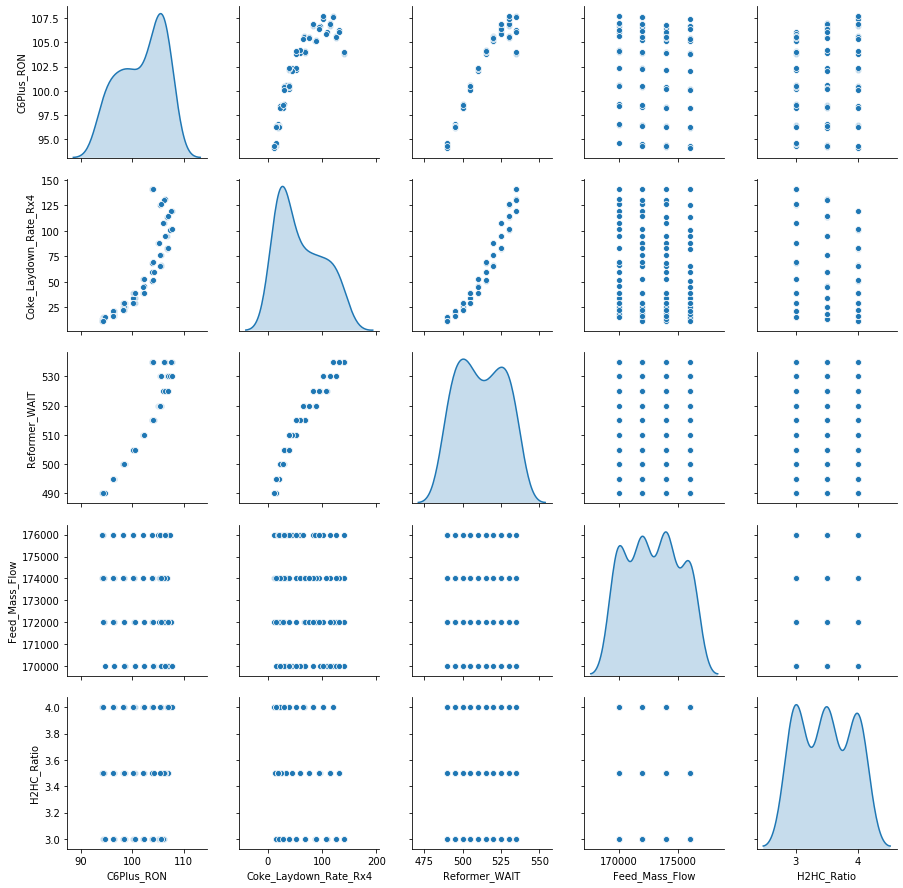

In [6]:
sns.pairplot(train_dataset[['C6Plus_RON','Coke_Laydown_Rate_Rx4', 'Reformer_WAIT','Feed_Mass_Flow','H2HC_Ratio']], diag_kind="kde")
plt.show()

Also look at the overall statistics:

In [7]:
train_stats = train_dataset.describe()
train_stats.pop('C6Plus_RON')
train_stats.pop('Coke_Laydown_Rate_Rx4')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Reformer_WAIT,96.0,512.187500,14.704323,490.0,500.0,510.0,525.0,535.0
Feed_Mass_Flow,96.0,172916.666667,2189.288116,170000.0,171500.0,172000.0,174000.0,176000.0
H2HC_Ratio,96.0,3.489583,0.410258,3.0,3.0,3.5,4.0,4.0


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [8]:
train_dataset.head()

,C6Plus_RON,Coke_Laydown_Rate_Rx4,Reformer_WAIT,Feed_Mass_Flow,H2HC_Ratio
54,102.20,52.47,510,174000.0,3.0
6,94.44,15.69,490,174000.0,3.0
25,98.57,25.19,500,170000.0,3.5
56,102.20,39.30,510,174000.0,4.0
80,105.50,65.91,520,174000.0,4.0


In [9]:
train_labels = train_dataset[['C6Plus_RON']]
test_labels = test_dataset[['C6Plus_RON']]
train_dataset.drop(['C6Plus_RON', 'Coke_Laydown_Rate_Rx4'],  axis = 1, inplace= True)
test_dataset.drop(['C6Plus_RON', 'Coke_Laydown_Rate_Rx4'],  axis = 1, inplace= True)

In [10]:
test_dataset.head()

,Reformer_WAIT,Feed_Mass_Flow,H2HC_Ratio
1,490,170000.0,3.5
2,490,170000.0,4.0
12,495,170000.0,3.0
23,495,176000.0,4.0
35,500,176000.0,4.0


### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [130]:
def build_model():
  model = keras.Sequential([
    layers.Dense(3, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(3, activation=tf.nn.relu),
    layers.Dense(3, activation=tf.nn.relu),
    layers.Dense(3, activation=tf.nn.relu),
    layers.Dense(3, activation=tf.nn.relu),
    layers.Dense(3, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [131]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [132]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_80 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_81 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_82 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_83 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_84 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 4         
Total para


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [133]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [138]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 20000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [139]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
9990,4481.723890,66.808365,4481.723633,4310.177246,65.513054,4310.177246,9990
9991,4481.325067,66.805374,4481.325195,4309.786133,65.510078,4309.786133,9991
9992,4480.926424,66.802391,4480.926270,4309.391602,65.507065,4309.391602,9992
9993,4480.524491,66.799377,4480.524902,4309.000000,65.504074,4309.000000,9993
9994,4480.124280,66.796387,4480.124023,4308.605469,65.501060,4308.605469,9994
9995,4479.722579,66.793381,4479.722656,4308.213379,65.498070,4308.213379,9995
9996,4479.322574,66.790382,4479.322754,4307.821289,65.495079,4307.821289,9996
9997,4478.923340,66.787392,4478.923340,4307.429688,65.492088,4307.429688,9997
9998,4478.522718,66.784401,4478.522949,4307.035156,65.489067,4307.035156,9998
9999,4478.121017,66.781395,4478.121094,4306.641602,65.486069,4306.641602,9999


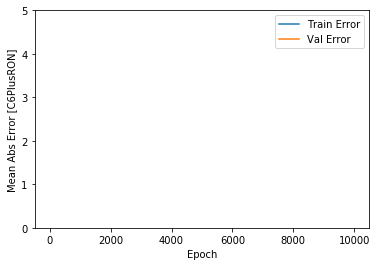

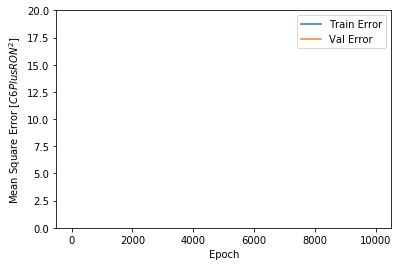

In [140]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [C6PlusRON]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$C6PlusRON^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [141]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

KeyboardInterrupt: 

The graph shows that on the validation set, the average error is usually around +/- 1.5 RON. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} C6PlusRON".format(mae))

### Make predictions

Finally, predict MPG values using data in the testing set:

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [C6PlusRON]')
plt.ylabel('Predictions [C6PlusRON]')
plt.axis('equal')
plt.axis('square')
plt.xlim([93,plt.xlim()[1]])
plt.ylim([93,plt.ylim()[1]])
_ = plt.plot([90, 107], [90, 107])
plt.show()


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

In [ ]:
error = test_predictions - np.array(test_labels)

plt.hist(error, bins = 25)

plt.xlabel("Prediction Error [C6PlusRON]")
_ = plt.ylabel("Count")
plt.show()

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.